- This notebook demonstrates the numerical results from Section 3. The code is designed to be user-friendly and can be used to analyze any antibiotic data with a selection of PD models. The user can choose a PD model and input their own PK and PD parameters. The code outputs, among other things, the value of $\tilde{D}$, an analytic and numerical analysis of the concavity of the Hill function as performed in this paper, and plots of the dose response curve, the treatment regimens, and the bacteria population curves.
- Run each cell in order. Last cell outputs results.
- Originally written with Python 3.12.5 on 20 January 2025
- Necessary packages: NumPy, SciPy, Matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import textwrap
import math as math

import drug_parameters as par  # parameter class


plt.rcParams["text.usetex"] = True

ModuleNotFoundError: No module named 'drug_parameters'

# Edit the following cell ONLY.

In [9]:
# specify PD model and antibiotic:

PD_model = "Regoes"  # options: "linear", "Regoes", "E_max"
drug_name = "Ampicillin"  # name of drug as string (not necessary)

# input dose response curve data here (only need to fill in the relevant
# parameters for the chosen PD model):

# linear parameters: necessary if PD_model="linear"
G_max = 0  # maximum net growth rate in absence of antibiotic (h^-1)
slope = 0  # slope of linear dose response curve

# Regoes parameters: necessary if PD_model="Regoes"
kappa = 1.1  # Hill coefficient
p_max = 0.88  # maximum (net) growth rate in absence of antibiotic (h^-1)
p_min = -6.5  # minimum (net) growth rate in presence of antibiotic (h^-1)
MIC = 0.02  # minimum inhibitory concentration of antibiotic (mg/L)


# E_max parameters: necessary if PD_model="E_max"
hill_coeff = 0  # Hill coefficient
G_max = 0  # maximum net growth rate in absence of antibiotic (h^-1)
E_max = 0  # maximum drug response (h^-1)
EC_50 = 0  # drug concentration at half-maximum drug response (mg/L)

# input PD parameters for decay model here:

half_life = 2.5  # half-life of antibiotic (h)
p_dose = 10  # dose size for periodic regimen (mg)
dose_period = 12  # dose period for periodic regimen (h)
volume = 53.2  # volume of distribution (L)

# toggle if needed for solving IVP:
# if you want to graph the y-axis as percent of initial bacteria, set
# initial_bac=100 and tol<=min_bac

initial_bac = 100  # initial bacteria value, default to 1e10.
min_bac = 1e-12  # stops integration at this value, default to 1.
tol = 1e-13  # tolerance for IVP solver, default to 1e-6. tol<min_bac necessary

# do not edit below this line ----------------------------------------------

params = par.parameters(
    PD_model=PD_model,
    drug_name=drug_name,
    G_max=G_max,
    slope=slope,
    kappa=kappa,
    p_max=p_max,
    p_min=p_min,
    MIC=MIC,
    hill_coeff=hill_coeff,
    E_max=E_max,
    EC_50=EC_50,
    half_life=half_life,
    p_dose=p_dose,
    dose_period=dose_period,
    volume=volume,
    initial_bac=initial_bac,
    min_bac=min_bac,
    tol=tol,
)

# Run all cells. Last cell produces results.

In [2]:
# Functions
def decay(t, lam, p_conc):
    return p_conc * np.exp(-lam * t)


def linear(dose, params):
    return params.slope * dose


def Regoes(dose, params):
    percent_MIC = (dose / params.MIC) ** params.kappa
    return ((params.p_max - params.p_min) * percent_MIC) / (
        percent_MIC - (params.p_min / params.p_max)
    )


def E_max(dose, params):
    return (
        params.E_max
        * (dose**params.hill_coeff)
        / (dose**params.hill_coeff + params.EC_50**params.hill_coeff)
    )


def periodic_diffeq(t, b, params, lam, p_conc, c_conc):
    if params.PD_model == "linear":
        return (params.G_max - linear(decay(t, lam, p_conc), params)) * b
    elif params.PD_model == "Regoes":
        return ((params.p_max) - Regoes(decay(t, lam, p_conc), params)) * b
    elif params.PD_model == "E_max":
        return (params.G_max - E_max(decay(t, lam, p_conc), params)) * b


def continuous_diffeq(t, b, params, lam, p_conc, c_conc):
    if params.PD_model == "linear":
        return (params.G_max - linear(c_conc, params)) * b
    elif params.PD_model == "Regoes":
        return (params.p_max - Regoes(c_conc, params)) * b
    elif params.PD_model == "E_max":
        return (params.G_max - E_max(c_conc, params)) * b


def event(t, b, params, lam, p_conc, c_conc):
    return b[0] - params.min_bac


event.terminal = True


def p_solution(params, lam, p_conc, c_conc):
    sol = solve_ivp(
        periodic_diffeq,
        (0, params.dose_period),
        [params.initial_bac],
        method="RK45",
        rtol=tol,
        atol=tol,
        events=event,
        args=(params, lam, p_conc, c_conc),
    )
    bacteria_values = sol.y[0]
    time_values = sol.t

    return time_values, bacteria_values


def c_solution(params, lam, p_conc, c_conc):
    sol = solve_ivp(
        continuous_diffeq,
        (0, params.dose_period),
        [params.initial_bac],
        method="RK45",
        rtol=tol,
        atol=tol,
        events=event,
        args=(params, lam, p_conc, c_conc),
    )
    bacteria_values = sol.y[0]
    time_values = sol.t

    return time_values, bacteria_values


def round_sigfigs(num, sig_figs):
    if num != 0:
        return round(
            num, -int(math.floor(math.log10(abs(num))) + (1 - sig_figs))
        )
    else:
        return 0  # Can't take the log of 0

In [3]:
# Main function which outputs results
def regimen_analysis(params):
    lam = np.log(2) / params.half_life
    p_conc = params.p_dose / params.volume  # initial periodic drug conc
    AUC = (p_conc / lam) * (1 - np.exp(-lam * params.dose_period))
    c_conc = AUC / params.dose_period  # continuous concentration
    continuous_rate = c_conc * params.volume
    p_conc_max = p_conc
    p_conc_min = p_conc * np.exp(-lam * params.dose_period)

    dose_vals = np.logspace(-3, 5, 5000)
    t_vals = np.linspace(0, params.dose_period, 5000)
    drug_vals = decay(t_vals, lam, p_conc)

    if PD_model == "linear":
        response_vals = linear(dose_vals, params)
        D_tilde = 0
    elif PD_model == "Regoes":
        response_vals = Regoes(dose_vals, params)
        if kappa > 1:
            D_tilde = params.MIC * (
                (-params.p_min / params.p_max)
                * ((params.kappa - 1) / (params.kappa + 1))
            ) ** (1 / params.kappa)
        else:
            D_tilde = 0
    elif PD_model == "E_max":
        response_vals = E_max(dose_vals, params)
        if hill_coeff > 1:
            D_tilde = params.EC_50 * (
                (params.hill_coeff - 1) / (params.hill_coeff + 1)
            ) ** (1 / params.hill_coeff)
        else:
            D_tilde = 0

    p_time_values, p_bacteria_values = p_solution(params, lam, p_conc, c_conc)
    c_time_values, c_bacteria_values = c_solution(params, lam, p_conc, c_conc)
    p_end_bac = p_bacteria_values[-1]
    c_end_bac = c_bacteria_values[-1]
    if p_time_values[-1] < params.dose_period:
        p_end_time = p_time_values[-1]
    else:
        p_end_time = params.dose_period

    if c_time_values[-1] < params.dose_period:
        c_end_time = c_time_values[-1]
    else:
        c_end_time = params.dose_period

    print("   ", "Antibiotic:", params.drug_name)
    print("   ", "PD Model:", params.PD_model)
    print("-" * 80)
    if params.PD_model == "linear":
        print(
            "D_tilde (Inflection point):", "None (linear dose response curve)"
        )
    elif D_tilde == 0 and params.PD_model != "linear":
        print("D_tilde (Inflection point):", "None (always concave down)")
    elif D_tilde > 0:
        print("D_tilde (Inflection point):", D_tilde, "mg/L")
    print("AUC of Periodic Regimen:", AUC, "mg*h/L")
    print("Continuous Regimen Concentration:", c_conc, "mg/L")
    print("Infusion Rate for Continuous Regimen:", continuous_rate, "mg/h")
    print("-" * 80)
    print("Max Periodic Regimen Concentration:", p_conc_max, "mg/L")
    print("Min Periodic Regimen Concentration:", p_conc_min, "mg/L")
    print()
    print("-" * 80)
    print(
        " " * 10, "Check which regimen performs better with concavity analysis:"
    )
    print("-" * 80)
    if params.PD_model == "linear":
        print(
            "Dose response curve is linear, so the periodic and continuous regimens perform equally well"
        )
    else:
        if D_tilde == 0:
            print(
                "Dose response curve is always concave down, so the continuous regimen will perform better"
            )
        else:
            if p_conc_max <= D_tilde:
                print(
                    "D_max <= D_tilde, so the periodic regimen will perform better"
                )
            elif p_conc_min >= D_tilde:
                print(
                    "D_min >= D_tilde, so the continuous regimen will perform better"
                )
            elif p_conc_min < D_tilde < p_conc_max:
                print(
                    "D_min < D_tilde < D_max, so concavity analysis cannot determine which regimen is better."
                )
    print()
    print("-" * 80)
    print(" " * 15, "Check which regimen performs better numerically:")
    print("-" * 80)
    if (
        p_end_bac > 1.0001 * params.min_bac
        or c_end_bac > 1.0001 * params.min_bac
    ):
        print("End Bacteria Value for Periodic Regimen:", p_end_bac)
        print("End Bacteria Value for Continuous Regimen:", c_end_bac)
        if params.PD_model == "linear":
            print(
                textwrap.fill(
                    "Periodic and continuous regimens perform equally well because dose response curve is linear (any difference in end bacteria value is due to numerical error)",
                    width=80,
                )
            )
        else:
            if p_end_bac < c_end_bac:
                print("Periodic regimen performs better")
            elif c_end_bac < p_end_bac:
                print("Continuous regimen performs better")
            elif c_end_bac == p_end_bac:
                print("Both regimens perform equally well")
    elif (
        p_end_bac < 1.0001 * params.min_bac
        and c_end_bac < 1.0001 * params.min_bac
    ):
        print("Time of death of bacteria for periodic regimen:", p_end_time)
        print("Time of death of bacteria for continuous regimen:", c_end_time)

        if params.PD_model == "linear":
            print(
                textwrap.fill(
                    "Periodic and continuous regimens perform equally well because dose response curve is linear (any difference in time of death is due to numerical error)",
                    width=80,
                )
            )
        else:
            if p_end_time < c_end_time:
                print("Periodic regimen performs better")
            elif c_end_time < p_end_time:
                print("Continuous regimen performs better")
            elif c_end_time == p_end_time:
                print("Both regimens perform equally well")
        print()
        print(
            textwrap.fill(
                "*Warning:* does not tell you which regimen performs better for a sufficiently high amount of bacteria. The periodic regimen's bacteria population will begin with a steeper slope, therefore it is possible for the periodic regimen to perform better in terms of time of death even when analytically, the continuous regimen should decrease the bacteria population by the larger amount at the end of the dose interval. Consider increasing initial_bac or decreasing min_bac for more information.",
                width=80,
            )
        )

    # Dose response curve
    plt.figure(figsize=(6, 4))
    plt.semilogx(dose_vals, response_vals, color="black", zorder=10)
    if D_tilde > 0:
        plt.axvline(
            D_tilde,
            color="green",
            linestyle="--",
            label=f"$\\tilde{{D}}=$ {round_sigfigs(D_tilde,2)} mg/L",
        )
    plt.axvline(
        p_conc_min,
        color="orange",
        alpha=0.4,
        label=f"$D_{{\\min}}=$ {round_sigfigs(p_conc_min,2)} mg/L",
    )
    plt.axvline(
        p_conc_max,
        color="orange",
        alpha=0.9,
        label=f"$D_{{\\max}}=$ {round_sigfigs(p_conc_max,2)} mg/L",
    )
    plt.axvline(
        c_conc,
        color="purple",
        alpha=0.5,
        linestyle=":",
        label=f"$D_C=$ {round_sigfigs(c_conc,2)} mg/L",
    )
    plt.xlabel("Drug Concentration (mg/L)")
    plt.ylabel("Effect on Net Growth Rate $h^{-1}$")
    plt.title(f"{params.PD_model} Model")
    plt.xlim(1e-3, 1e5)
    plt.ylim(0, (params.p_max - params.p_min) * 1.1)
    plt.legend()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
    # Drug concentrations
    axs[0].plot(
        t_vals, drug_vals, color="red", label="Periodic Drug Concentration"
    )
    axs[0].axhline(c_conc, color="blue", label="Continuous Drug Concentration")
    axs[0].set_xlabel("Time (h)")
    axs[0].set_ylabel("Drug Concentration (mg/L)")
    axs[0].set_title("Drug Concentration")
    axs[0].set_xlim(0, params.dose_period)
    axs[0].set_ylim(0, 1.1 * p_conc)
    axs[0].legend()

    # Bacteria populations
    axs[1].semilogy(
        p_time_values,
        p_bacteria_values,
        label="Periodic Regimen Bac",
        color="red",
    )
    axs[1].semilogy(
        c_time_values,
        c_bacteria_values,
        label="Continuous Regimen Bac",
        color="blue",
    )
    axs[1].set_xlabel("Time (h)")
    axs[1].set_ylabel("Bacteria Value")
    axs[1].set_title("Bacteria Population")
    axs[1].set_xlim(0, params.dose_period)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    Antibiotic: Cipro
    PD Model: Regoes
--------------------------------------------------------------------------------
D_tilde (Inflection point): 0.007735615865315817 mg/L
AUC of Periodic Regimen: 196.0864950432417 mg*h/L
Continuous Regimen Concentration: 16.340541253603476 mg/L
Infusion Rate for Continuous Regimen: 869.316794691705 mg/h
--------------------------------------------------------------------------------
Max Periodic Regimen Concentration: 56.39097744360902 mg/L
Min Periodic Regimen Concentration: 2.024256969567144 mg/L

--------------------------------------------------------------------------------
           Check which regimen performs better with concavity analysis:
--------------------------------------------------------------------------------
D_min >= D_tilde, so the continuous regimen will perform better

--------------------------------------------------------------------------------
                Check which regimen performs better numerically:
---------

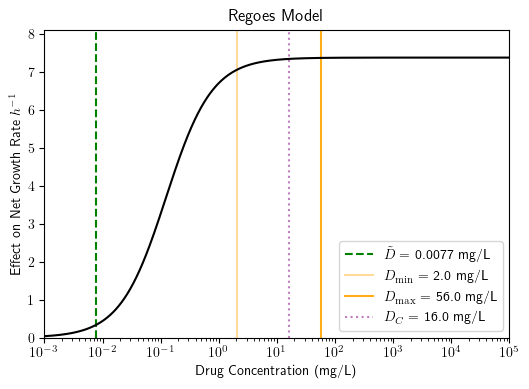

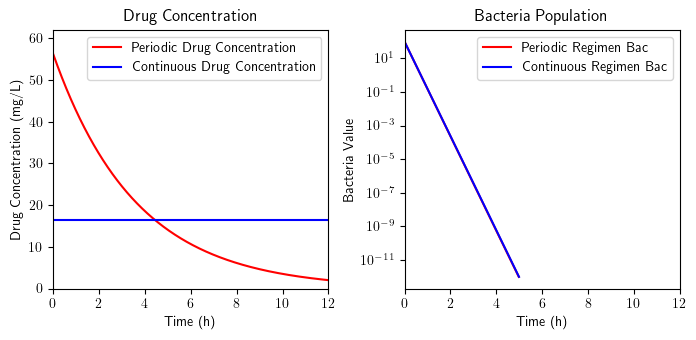

In [10]:
# run this cell
regimen_analysis(params)